<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/image_captioning/Image%20to%20Latex%20with%20Beam%20Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IM2LATEX Dataset

In [1]:
!mkdir data
!cd data

In [2]:
!wget -P data http://lstm.seas.harvard.edu/latex/data/im2latex_validate_filter.lst
!wget -P data http://lstm.seas.harvard.edu/latex/data/im2latex_train_filter.lst
!wget -P data http://lstm.seas.harvard.edu/latex/data/im2latex_test_filter.lst
!wget -P data http://lstm.seas.harvard.edu/latex/data/formula_images_processed.tar.gz
!wget -P data http://lstm.seas.harvard.edu/latex/data/im2latex_formulas.norm.lst
!tar -zxf data/formula_images_processed.tar.gz -C data/

--2020-07-27 17:12:20--  http://lstm.seas.harvard.edu/latex/data/im2latex_validate_filter.lst
Resolving lstm.seas.harvard.edu (lstm.seas.harvard.edu)... 52.32.77.68
Connecting to lstm.seas.harvard.edu (lstm.seas.harvard.edu)|52.32.77.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175153 (171K) [text/plain]
Saving to: ‘data/im2latex_validate_filter.lst’

im2latex_validate_f 100%[===================>] 171.05K   329KB/s    in 0.5s    

2020-07-27 17:12:21 (329 KB/s) - ‘data/im2latex_validate_filter.lst’ saved [175153/175153]

--2020-07-27 17:12:26--  http://lstm.seas.harvard.edu/latex/data/im2latex_train_filter.lst
Resolving lstm.seas.harvard.edu (lstm.seas.harvard.edu)... 52.32.77.68
Connecting to lstm.seas.harvard.edu (lstm.seas.harvard.edu)|52.32.77.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1575352 (1.5M) [text/plain]
Saving to: ‘data/im2latex_train_filter.lst’

im2latex_train_filt 100%[===================>]   1.50M  1.41MB

In [3]:
!ls data

formula_images_processed	 im2latex_test_filter.lst
formula_images_processed.tar.gz  im2latex_train_filter.lst
im2latex_formulas.norm.lst	 im2latex_validate_filter.lst


In [4]:
data_path = "data"

### Imports

In [5]:
import os
import time
import math
import pickle
import numpy as np
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Exploration

In [7]:
# formuals file
formulas_file = os.path.join(data_path, "im2latex_formulas.norm.lst")
with open(formulas_file, 'r') as f:
    formulas = [formula.split('\n')[0] for formula in f.readlines()]

In [8]:
train_formulas_file = os.path.join(data_path, "im2latex_train_filter.lst")
with open(train_formulas_file, 'r') as f:
    # img_name, formula_id= line.strip('\n').split()
    train_formulas = [line.strip('\n').split() for line in f.readlines()]

In [9]:
len(train_formulas)

75275

In [10]:
train_formulas[0]

['66667cee5b.png', '2']

In [11]:
temp = os.listdir(os.path.join(data_path, "formula_images_processed"))
len(temp)

103536

(<matplotlib.image.AxesImage at 0x7f3b1957d160>,
 '\\widetilde \\gamma _ { \\mathrm { h o p f } } \\simeq \\sum _ { n > 0 } \\widetilde { G } _ { n } { \\frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }')

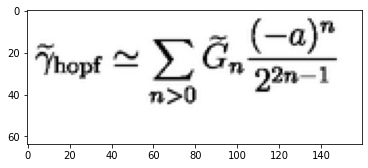

In [12]:
img_path = os.path.join(data_path, "formula_images_processed", train_formulas[0][0])
img = Image.open(img_path)
plt.imshow(np.asarray(img)), formulas[int(train_formulas[0][1])]

(<matplotlib.image.AxesImage at 0x7f3b19046898>,
 'e x p \\left( - \\frac { \\partial } { \\partial \\alpha _ { j } } \\theta ^ { j k } \\frac { \\partial } { \\partial \\alpha _ { k } } \\right)')

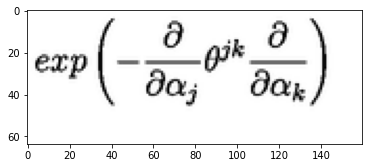

In [13]:
img_path = os.path.join(data_path, "formula_images_processed", train_formulas[10][0])
img = Image.open(img_path)
plt.imshow(np.asarray(img)), formulas[int(train_formulas[10][1])]

### Pre-processing

Since the dataset is huge, I will be taking only a subset of it. You can take the complete dataset based on the available RAM

In [14]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

In [19]:
def preprocess(data_dir, split, transform):
    assert split in ["train", "validate", "test"]
    print(f"Processing {split} data...")

    if split == "train":
        max_samples = 60000
    elif split == "validate":
        max_samples = 1000
    elif split == "test":
        max_samples = 1000
    
    # images directory
    images_dir = os.path.join(data_dir, "formula_images_processed")
    
    # formuals file
    formulas_file = os.path.join(data_dir, "im2latex_formulas.norm.lst")
    with open(formulas_file, 'r') as f:
        formulas = [formula.split('\n')[0] for formula in f.readlines()]
    
    split_file = os.path.join(data_dir, f"im2latex_{split}_filter.lst")
    pairs = []
    count = 0
    size = [128, 32]
    with open(split_file, 'r') as f:
        for line in f:
            img_name, formula_id = line.strip('\n').split()
            img_path = os.path.join(images_dir, img_name)
            img = Image.open(img_path)
            img = resize_image(img, size)
            img_tensor = transform(img)
            img_tensor = img_tensor / 255.
            formula = formulas[int(formula_id)]
            pair = (img_tensor, formula)
            pairs.append(pair)
            count += 1
            if count == max_samples:
                break
    
    pairs.sort(key=img_size)
    # save the formulas used in training for building vocabulary
    if split == "train":
        sampled_formulas = [form for (img, form) in pairs]
        form_file = os.path.join(data_dir, f"{split}_sampled_formula.pkl")
        print("saving sampled formulas...")
        with open(form_file, 'wb') as f:
            pickle.dump(sampled_formulas, f)

    out_file = os.path.join(data_dir, f"{split}.pkl")
    torch.save(pairs, out_file)
    print(f"Completed processing {split} data")

In [20]:
def img_size(pair):
    img, formula = pair
    return tuple(img.size())

In [21]:
%%time
transform = transforms.ToTensor()

preprocess(data_path, "train", transform)
preprocess(data_path, "validate", transform)
preprocess(data_path, "test", transform)

Processing train data...
saving sampled formulas...
Completed processing train data
Processing validate data...
Completed processing validate data
Processing test data...
Completed processing test data
CPU times: user 1min 2s, sys: 6.62 s, total: 1min 8s
Wall time: 1min 51s


### Vocabulary

In [22]:
PAD_TOKEN = 0
START_TOKEN = 1
END_TOKEN = 2
UNK_TOKEN = 3

In [23]:
class Vocab(object):
    def __init__(self):
        self.sign2id = {
            "<s>": START_TOKEN,
            "</s>": END_TOKEN,
            "<pad>": PAD_TOKEN,
            "<unk>": UNK_TOKEN
        }

        self.id2sign = dict((id, sign) for sign, id in self.sign2id.items())
        self.length = 4
    
    def add_sign(self, sign):
        if sign not in self.sign2id:
            self.sign2id[sign] = self.length
            self.id2sign[self.length] = sign
            self.length += 1
    
    def __len__(self):
        return self.length
    
    def __call__(self, sign):
        if not sign in self.sign2id:
            return self.sign2id['<unk>']
        return self.sign2id[sign]

In [24]:
def build_vocab(data_dir, min_count=10):
    vocab = Vocab()
    counter = Counter()

    with open(os.path.join(data_dir, 'train_sampled_formula.pkl'), 'rb') as f:
        formulas = pickle.load(f)

    for formula in formulas:
        counter.update(formula.split())

    for word, count in counter.most_common():
        if count >= min_count:
            vocab.add_sign(word)
    
    vocab_file = os.path.join(data_dir, 'vocab.pkl')
    print("saving vocabulary...")
    with open(vocab_file, 'wb') as f:
        pickle.dump(vocab, f)

In [25]:
def load_vocab(data_dir):
    with open(os.path.join(data_dir, 'vocab.pkl'), 'rb') as f:
        vocab = pickle.load(f)
    return vocab

In [26]:
%%time
build_vocab(data_path)

saving vocabulary...
CPU times: user 527 ms, sys: 3.95 ms, total: 531 ms
Wall time: 533 ms


In [27]:
vocab = load_vocab(data_path)

### Dataset

In [28]:
class Im2LatexDataset(data.Dataset):
    def __init__(self, data_dir, split):
        assert split in {'train', 'validate', 'test'}
        self.data_dir = data_dir
        self.split = split
        self.data = self._load_data()
    
    def _load_data(self):
        pairs = torch.load(os.path.join(self.data_dir, f"{self.split}.pkl"))
        for i, (img, formula) in enumerate(pairs):
            pair = (img, " ".join(formula.split()))
            pairs[i] = pair
        return pairs

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        img, formula = self.data[item]
        formula = formula.split()
        tokens = []
        tokens.append(vocab('<s>'))
        tokens.extend([vocab(sign) for sign in formula])
        tokens.append(vocab('</s>'))

        formula = torch.Tensor(tokens)
        return img, formula

In [29]:
%%time
train_dataset = Im2LatexDataset(data_path, 'train')
valid_dataset = Im2LatexDataset(data_path, 'validate')
test_dataset = Im2LatexDataset(data_path, 'test')

CPU times: user 1.93 s, sys: 1.4 s, total: 3.32 s
Wall time: 3.33 s


### DataLoader

In [30]:
torch.cuda.empty_cache()

In [31]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, formulas = zip(*data)

    # merge images
    images = torch.stack(images, 0)

    lengths = [len(form) for form in formulas]
    targets = torch.zeros(len(formulas), max(lengths)).long()
    for i, form in enumerate(formulas):
        end = lengths[i]
        targets[i, :end] = form[:end]
    
    return images, targets, lengths

In [33]:
batch_size = 64

In [34]:
train_data_loader = data.DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, batch_size, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=collate_fn)

In [35]:
# sample check
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape, len(sample[2])

(torch.Size([64, 3, 32, 128]), torch.Size([64, 126]), 64)

### Positional Encoding

In [36]:
class PositionalEncoding(nn.Module):
    """
    Implements the positional encoding.
    There are other ways of implementing positional encoding.
    Below mentioned is the way where the positional encoding is fixed.
    Other way is to make that as a learnable using: nn.Embedding(max_len, d_model)
    Paper claims there is not much of a difference between either ways.
    """
    def __init__(self, d_model, dropout, max_len=512):
        super().__init__()

        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))

        # pe(pos, 2i) = sin(pos / (10000 ^ (2i/d_model)))
        pe[:, 0::2] = torch.sin(position * div_term)

        # pe(pos, 2i+1) = cos(pos / (10000 ^ (2i/d_model)))
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        # pe => [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x => [batch_size, seq_len, d_model]
        
        # get the positional embeddings of word and add it
        x = x + self.pe[:, :x.shape[1], :]
        # x => [batch_size, seq_len, d_model]

        return self.dropout(x)

### Encoder

In [37]:
class Encoder(nn.Module):
    def __init__(self, enc_out_dim=512):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(1, 1),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, enc_out_dim, 3, 1, 1),
            nn.ReLU()
        )

        self.pos = PositionalEncoding(enc_out_dim, 0.3)

    def forward(self, imgs):
        # imgs => [batch, 3, 32, 128]

        features = self.cnn(imgs)
        # features => [batch, 512, 2, 8]

        features = features.permute(0, 2, 3, 1)
        batch, H, W, _ = features.shape
        encoded_imgs = features.contiguous().view(batch, H*W, -1)
        encoded_imgs = self.pos(encoded_imgs)
        return encoded_imgs

### Attention

In [38]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()

        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)

        self.full_attn = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, decoder_hidden):
        # encoder_out => [batch_size, num_pixels, enc_dim]
        # decoder_hidden => [batch_size, dec_dim]

        enc_attn = self.encoder_attn(encoder_out)
        # enc_attn => [batch_size, num_pixels, attn_dim]

        dec_attn = self.decoder_attn(decoder_hidden)
        # dec_attn => [batch_size, attn_dim]

        attn = self.full_attn(self.relu(enc_attn + dec_attn.unsqueeze(1)))
        # attn => [batch_size, num_pixels, 1]

        attn = attn.squeeze(2)
        # attn => [batch_size, num_pixels]

        alpha = self.softmax(attn)

        weighted = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        # weighted => [batch_size, encoder_dim]

        return weighted, alpha

### Decoder

In [39]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, decoder_dim, attention_dim, encoder_dim=512, dropout=0.3):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_TOKEN)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.lstm = nn.LSTM(
            emb_dim,
            decoder_dim,
            batch_first=True
        )

        self.out = nn.Linear(emb_dim + encoder_dim + decoder_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
    

    def forward(self, trg, hidden, cell, encoder_out):
        # trg => [batch_size, 1]

        embedded = self.embedding(trg)
        # embedded => [batch_size, 1, emb_dim]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output => [batch_size, 1, hid_dim]
        # hidden, cell => [num_layers, batch_size, hid_dim]

        weighted, alpha = self.attention(encoder_out, output[:, -1, :])
        # weighted => [batch_size, encoder_dim]
        # alpha => [batch_size, num_pixels]

        combined = torch.cat([embedded.squeeze(1), weighted, output[:, -1, :]], dim=1)
        # combined => [batch_size, emb_dim + encoder_dim + hid_dim]

        logits = self.out(self.dropout(combined))
        # logits => [batch_size, vocab_size]

        return logits, hidden, cell, alpha


In [40]:
class Img2LaTeX(nn.Module):
    def __init__(self, encoder, decoder, encoder_dim, decoder_dim, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

    def init_hidden_state(self, encoder_out):
        # encoder_out => [batch_size, num_pixels, encoder_dim]
        mean_enc = torch.mean(encoder_out, dim=1)
        h = self.init_h(mean_enc)
        c = self.init_c(mean_enc)
        # h, c=> [batch_size, decoder_dim]

        return h, c
    
    def forward(self, images, formulas, lengths):
        # images => [batch_size, 3, 32, 128]
        # formulas => [batch_size, max_seq_len]
        # lengths => [batch_size]

        encoded_images = self.encoder(images)
        # encoded_images => [batch_size, 2, 8, 512]

        batch_size = encoded_images.size(0)
        encoder_dim = encoded_images.size(-1)
        encoder_out = encoded_images.view(batch_size, -1, encoder_dim)
        # encoder_
        hidden, cell = self.init_hidden_state(encoder_out)

        hidden = hidden.unsqueeze(0)
        cell = cell.unsqueeze(0)
        # hidden, cell => [1, batch_size, decoder_dim]

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = [length - 1 for length in lengths]

        trg_len = formulas.size(1)
        output_dim = self.decoder.vocab_size
        outputs = torch.zeros(batch_size, trg_len, output_dim).to(self.device)

        dec_inp = formulas[:, 0]

        for t in range(max(decode_lengths)):
            # calculate batch_size at each time step, so that only that part
            # will be used to train the model. (similar to pack padded sequence)
            batch_size_t = sum([l > t for l in decode_lengths])

            output, hidden, cell, alpha = self.decoder(
                dec_inp[:batch_size_t].unsqueeze(1),
                hidden[:, :batch_size_t, :],
                cell[:, :batch_size_t, :],
                encoder_out[:batch_size_t]
            )

            # save the output
            outputs[:batch_size_t, t, :] = output

            dec_inp = formulas[:batch_size_t, t]
        
        return outputs

### Model

In [41]:
embed_dim = 256
encoder_dim = 512
decoder_dim = 512
attention_dim = 512
dropout = 0.3

In [42]:
encoder = Encoder(encoder_dim).to(device)
decoder = Decoder(len(vocab), embed_dim, decoder_dim, attention_dim, encoder_dim, dropout).to(device)
model = Img2LaTeX(encoder, decoder, encoder_dim, decoder_dim, device).to(device)

### Optimizer & Loss

In [43]:
lr = 3e-3
min_lr = 3e-4
lr_decay=0.5
lr_patience=2

In [45]:
params = model.parameters()
optimizer = optim.Adam(params, lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', lr_decay, lr_patience, verbose=True, min_lr=min_lr)

### Training Method

In [48]:
def train(model, data_loader):
    model.train()
    epoch_loss = 0
    total_step = len(data_loader)

    for i, (images, formulas, lengths) in enumerate(data_loader):
        optimizer.zero_grad()
        images = images.to(device)
        formulas = formulas.to(device)

        output = model(images, formulas, lengths)
        decode_lengths = [length - 1 for length in lengths]

        outputs = nn.utils.rnn.pack_padded_sequence(output, decode_lengths, batch_first=True)[0]
        targets = nn.utils.rnn.pack_padded_sequence(formulas, decode_lengths, batch_first=True)[0]

        loss = criterion(outputs, targets)

        loss.backward()
        
        # clip the gradients
        torch.nn.utils.clip_grad_norm_(params, 2.)
        optimizer.step()

        epoch_loss += loss.item()

        # Print log info
        if i % 100 == 0:
            print(f'Step [{i}/{total_step}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')
    return epoch_loss / total_step    

### Evaluation Method

In [49]:
def evaluate(model, data_loader):
    model.eval()
    epoch_loss = 0
    total_step = len(data_loader)

    with torch.no_grad():
        for i, (images, formulas, lengths) in enumerate(data_loader):
            images = images.to(device)
            formulas = formulas.to(device)

            output = model(images, formulas, lengths)
            decode_lengths = [length - 1 for length in lengths]

            outputs = nn.utils.rnn.pack_padded_sequence(output, decode_lengths, batch_first=True)[0]
            targets = nn.utils.rnn.pack_padded_sequence(formulas, decode_lengths, batch_first=True)[0]

            loss = criterion(outputs, targets)

            epoch_loss += loss.item()

            # Print log info
            if i % 50 == 0:
                print(f'Val Step [{i}/{total_step}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')
    return epoch_loss / total_step    

### Training

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins*60)
    return elapsed_mins, elapsed_secs

In [51]:
num_epochs = 5

In [52]:
best_val_loss = float('inf')
for epoch in range(num_epochs):

    start_time = time.time()
    train_loss = train(model, train_data_loader)
    val_loss = evaluate(model, valid_data_loader)
    end_time = time.time()
    
    scheduler.step(val_loss)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss <  best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model.ckpt')

    print(f"Epoch: {epoch+1} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.4f}, Train PPL: {np.exp(train_loss):5.4f}")
    print(f"\tVal Loss: {val_loss:.4f}, Val PPL: {np.exp(val_loss):5.4f}")


Step [0/938], Loss: 6.0197, Perplexity: 411.4353
Step [100/938], Loss: 2.5103, Perplexity: 12.3086
Step [200/938], Loss: 2.2608, Perplexity: 9.5904
Step [300/938], Loss: 2.1558, Perplexity: 8.6346
Step [400/938], Loss: 2.1303, Perplexity: 8.4177
Step [500/938], Loss: 1.9597, Perplexity: 7.0974
Step [600/938], Loss: 1.9987, Perplexity: 7.3796
Step [700/938], Loss: 1.9390, Perplexity: 6.9520
Step [800/938], Loss: 1.9612, Perplexity: 7.1082
Step [900/938], Loss: 1.8780, Perplexity: 6.5406
Val Step [0/16], Loss: 1.9018, Perplexity: 6.6981
Epoch: 1 | Time: 9m 37.98337531089783s
	Train Loss: 2.1872, Train PPL: 8.9102
	Val Loss: 1.8862, Val PPL: 6.5943
Step [0/938], Loss: 1.9317, Perplexity: 6.9009
Step [100/938], Loss: 1.9587, Perplexity: 7.0903
Step [200/938], Loss: 1.8905, Perplexity: 6.6228
Step [300/938], Loss: 1.8656, Perplexity: 6.4599
Step [400/938], Loss: 1.9390, Perplexity: 6.9520
Step [500/938], Loss: 1.8604, Perplexity: 6.4265
Step [600/938], Loss: 1.8996, Perplexity: 6.6834
Step 

### Testing

In [53]:
vocab_path = "data/vocab.pkl"
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [54]:
# Build models
encoder = Encoder(encoder_dim).to(device)
decoder = Decoder(len(vocab), embed_dim, decoder_dim, attention_dim, encoder_dim, dropout).to(device)
model = Img2LaTeX(encoder, decoder, encoder_dim, decoder_dim, device).to(device)

model.eval()

Img2LaTeX(
  (encoder): Encoder(
    (cnn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (15): Conv2d(256, 512, ker

In [66]:
model_path = "model.ckpt"

# Load the trained model parameters
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [67]:
test_loss = evaluate(model, test_data_loader)
print(f"Test Loss: {test_loss:.4f} | Test PPL: {np.exp(test_loss):5.4f}")

Val Step [0/16], Loss: 1.6707, Perplexity: 5.3160
Test Loss: 1.6598 | Test PPL: 5.2581


### Inference

In [68]:
def load_image(image_path, transform):
    image = Image.open(image_path)
    img = resize_image(image, [128, 32])
    img_tensor = transform(img).unsqueeze(0)
    img_tensor = img_tensor / 255.
    return img_tensor

In [69]:
def greedy_generated_formula(image_path, max_len=64):
    # Prepare an image
    transform = transforms.ToTensor()
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    with torch.no_grad():
        encoded_image = model.encoder(image_tensor)
        # encoded_image => [1, 2, 8, 512]
        
        batch_size = encoded_image.size(0)
        encoder_dim = encoded_image.size(-1)
        encoder_out = encoded_image.view(batch_size, -1, encoder_dim)
        # encoder_out => [1, 16, 512]
        
        num_pixels = encoder_out.size(1)

        hidden, cell = model.init_hidden_state(encoder_out)
        # hidden, cell => [1, decoder_dim]

        hidden = hidden.unsqueeze(0)
        cell = cell.unsqueeze(0)
        # hidden, cell => [1, 1, decoder_dim]

        dec_inp = torch.LongTensor([vocab('<s>')]).to(device)
        sampled_ids = []

        for t in range(1, max_len):
            output, hidden, cell, _ = model.decoder(dec_inp.unsqueeze(1), hidden, cell, encoder_out)
            top1 = output.argmax(1)
            dec_inp = top1
            sampled_ids.append(top1.item())

    # Convert word_ids to words
    sampled_formula = []
    for sign_id in sampled_ids[1:]:
        sign = vocab.id2sign[sign_id]
        if sign == '</s>':
            break
        sampled_formula.append(sign)
    formula = ' '.join(sampled_formula)

    return formula

In [70]:
def beam_generated_formulas(image_path, max_len=64, beam_size=5, length_norm_coefficient=0.6):
    with torch.no_grad():
        k = beam_size

        # vocab size
        vocab_size = model.decoder.vocab_size

        # Prepare an image
        transform = transforms.ToTensor()
        image = load_image(image_path, transform)

        image_tensor = image.to(device)

        encoded_image = model.encoder(image_tensor)
        # encoded_image => [1, 2, 8, 512]

        batch_size = encoded_image.size(0)
        encoder_dim = encoded_image.size(-1)
        encoder_out = encoded_image.view(batch_size, -1, encoder_dim)
        # encoder_out => [1, 16, 512]

        num_pixels = encoder_out.shape[1]   # 196

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[vocab('<s>')]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

         # Lists to store completed sequences, their alphas and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        hidden, cell = model.init_hidden_state(encoder_out)

        hidden = hidden.unsqueeze(0)
        cell = cell.unsqueeze(0)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            logits, hidden, cell, _ = model.decoder(k_prev_words, hidden, cell, encoder_out)
            
            # logits => [s, vocab_size]
            scores = F.log_softmax(logits, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                            next_word != vocab('</s>')]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                norm = math.pow(((5 + step) / (5 + 1)), length_norm_coefficient)
                complete_seqs_scores.extend((top_k_scores[complete_inds]/norm).tolist())
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k <= 0:
                break
            seqs = seqs[incomplete_inds]
            hidden = hidden[:, prev_word_inds[incomplete_inds], :]
            cell = cell[:, prev_word_inds[incomplete_inds], :]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > max_len:
                break
            step += 1

        # If there is not a single completed hypothesis, use partial hypotheses
        if len(complete_seqs) == 0:
            complete_seqs = seqs.tolist()
            complete_seqs_scores = top_k_scores.tolist()
        
        formulas = []
        i = complete_seqs_scores.index(max(complete_seqs_scores))

        for seq, score in zip(complete_seqs, complete_seqs_scores):
            # seq = complete_seqs[i]

            # Convert word_ids to words
            sampled_formula = []
            for sign_id in seq[2:]:
                sign = vocab.id2sign[sign_id]
                if sign == '</s>':
                    break
                sampled_formula.append(sign)

            formula = ' '.join(sampled_formula)
            formulas.append(formula)
        
        return formulas

Actual: e x p \left( - \frac { \partial } { \partial \alpha _ { j } } \theta ^ { j k } \frac { \partial } { \partial \alpha _ { k } } \right)

 Greedy generated forumula
--------------------------------------------------
{ \cal L } = - \frac { 1 } { 2 } ( \partial _ { \mu } \phi ) ^ { 2 } + \frac { 1 } { 2 } \phi ^ { 2 } + \frac { 1 } { 2 } \phi ^ { 2 } + \frac { 1 } { 2 } \phi ^ {

Beam generated captions
--------------------------------------------------
{ \cal L } = \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi - \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi - \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi
{ \cal L } = \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi - \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi - \frac { 1 } { 2 } \partial ^ { \mu } \phi \partial ^ { \mu } \phi
{ \cal L } = \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi - \frac { 1 } { 2 } \partial _

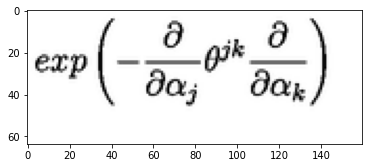

In [71]:
image_path = os.path.join(data_path, "formula_images_processed", train_formulas[10][0])
actual_formula = formulas[int(train_formulas[10][1])]
greedy_formula = greedy_generated_formula(image_path)
beam_formulas = beam_generated_formulas(image_path)
# Print out the image and the generated formula
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Actual: {actual_formula}")
print(f"\n Greedy generated forumula")
print("-"*50)
print(greedy_formula)
print("\nBeam generated captions")
print("-"*50)
for s in beam_formulas:
    print(s)

Rendering the Predicted:

${ \cal L } = - \frac { 1 } { 2 } ( \partial _ { \mu } \phi ) ^ { 2 } + \frac { 1 } { 2 } \phi ^ { 2 } + \frac { 1 } { 2 } \phi ^ { 2 } + \frac { 1 } { 2 } \phi$

${ \cal L } = \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi - \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi - \frac { 1 } { 2 } \partial _ { \mu } \phi \partial ^ { \mu } \phi$

$( \Delta _ { 1 } ) _ { \alpha } = 0 , \quad ( \Delta _ { \alpha } P _ { \alpha } ) = 0 , \quad ( \Delta _ { \alpha } P _ { \alpha } ) = 0 , \quad ( \Delta _ { \alpha } P _ { \alpha } ) = 0 $